# NN Model

In [1]:
# Import needed libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from fireTS.models import NARX, DirectAutoRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from matplotlib import pyplot as plt
%matplotlib inline

/home/dhan/miniconda3/envs/ML/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Memasukkan dataset.
data_file_path = '../Data/data.xlsx'
data = pd.read_excel(data_file_path)

data_features = ['HT','AC','To','RD']
y  = data[['Td','RH']]
yr = data[['Td_SP','RH_SP']]
X  = data[['AC','HT']]

# Memisahkan data tes
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.05, shuffle=False, random_state=15)
# Memisahkan data train dan data validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(15/95), shuffle=False, random_state=2019)

In [3]:
# Membuat model MLP
MLP_Td = MLPRegressor(random_state = 1, hidden_layer_sizes=(91), max_iter = 5000)
MLP_RH = MLPRegressor(random_state = 1, hidden_layer_sizes=(91), max_iter = 5000)

# Membuat model NARX
p_value, q_value, d_value = 1, [1]*2, [0]*2

# # NARX Parallel Architecture
# NARX_Td = NARX(MLP_Td, auto_order=p_value, exog_order=q_value, exog_delay=d_value)
# NARX_RH = NARX(MLP_RH, auto_order=p_value, exog_order=q_value, exog_delay=d_value)

# NARX Series-Parallel Architecture
NARX_Td = DirectAutoRegressor(MLP_Td, auto_order=p_value, exog_order=q_value, exog_delay=d_value, pred_step=1)
NARX_RH = DirectAutoRegressor(MLP_RH, auto_order=p_value, exog_order=q_value, exog_delay=d_value, pred_step=1)

In [4]:
# score function
def kinerja(y_target, y_pred, method="evar"):
    mask = np.isnan(y_target) | np.isnan(y_pred)
    if method == "evar":
        return explained_variance_score(y_target[~mask], y_pred[~mask])
    elif method == "r2":
        return r2_score(y_target[~mask], y_pred[~mask])
    elif method == "mse":
        return mean_squared_error(y_target[~mask], y_pred[~mask])
    elif method == "mae":
        return mean_absolute_error(y_target[~mask], y_pred[~mask])

### Prediction

In [5]:
# Training Proses
NARX_Td.fit(X_train, y_train.Td)
NARX_RH.fit(X_train, y_train.RH)

In [6]:
# Prediction
# Td_pred = NARX_Td.predict(X_val, y_val.Td, step=1)  # NARX Parallel Architecture
Td_pred = NARX_Td.predict(X_val, y_val.Td)            # NARX Series-Parallel Architecture
Td_pred = pd.Series(Td_pred, index=y_val.index)

# RH_pred = NARX_RH.predict(X_val, y_val.RH, step=1)  # NARX Parallel Architecture
RH_pred = NARX_RH.predict(X_val, y_val.RH)            # NARX Series-Parallel Architecture
RH_pred = pd.Series(RH_pred, index=y_val.index)

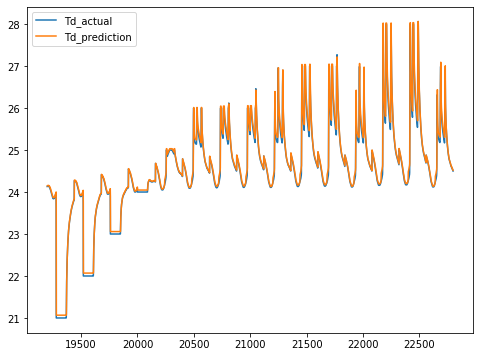

In [7]:
# Plot result
plt.figure(figsize=(8,6))
y_val.Td.plot(label='Td_actual')
Td_pred.plot(label='Td_prediction')
plt.legend()

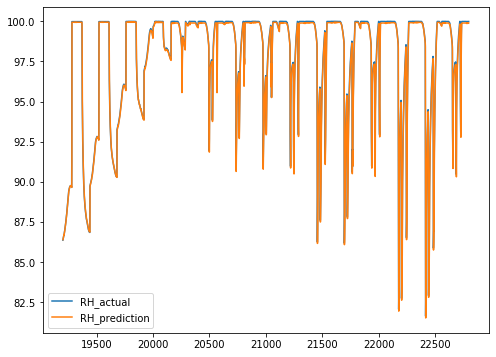

In [8]:
# Plot result
plt.figure(figsize=(8,6))
y_val.RH.plot(label='RH_actual')
RH_pred.plot(label='RH_prediction')
plt.legend()

In [9]:
# Td Performance Evaluation
# Td_pred = NARX_Td.predict(X_test, y_test.Td, step=1) # NARX Parallel Architecture
Td_pred = NARX_Td.predict(X_test, y_test.Td)           # NARX Series-Parallel Architecture
Td_pred = pd.Series(Td_pred, index=y_test.index)

EVar = round(kinerja(y_test.Td, Td_pred, method='evar')*100, 2)
R2   = round(kinerja(y_test.Td, Td_pred, method='r2')*100, 2)
RMSE = round(kinerja(y_test.Td, Td_pred, method='mse')**0.5, 2)
MAE  = round(kinerja(y_test.Td, Td_pred, method='mae'), 2)
print("Td Performance evaluation based on Test Data")
print("EVar = {}% | R2 = {}% | RMSE = {} | MAE = {}".format(EVar, R2, RMSE, MAE))
print()

# RH Performance Evaluation
# RH_pred = NARX_RH.predict(X_test, y_test.RH, step=1) # NARX Parallel Architecture
RH_pred = NARX_RH.predict(X_test, y_test.RH)           # NARX Series-Parallel Architecture
RH_pred = pd.Series(RH_pred, index=y_test.index)

EVar = round(kinerja(y_test.RH, RH_pred, method='evar')*100, 2)
R2   = round(kinerja(y_test.RH, RH_pred, method='r2')*100, 2)
RMSE = round(kinerja(y_test.RH, RH_pred, method='mse')**0.5, 2)
MAE  = round(kinerja(y_test.RH, RH_pred, method='mae'), 2)
print("RH Performance evaluation based on Test Data")
print("EVar = {}% | R2 = {}% | RMSE = {} | MAE = {}".format(EVar, R2, RMSE, MAE))
print()

Td Performance evaluation based on Test Data
EVar = 96.38% | R2 = 96.17% | RMSE = 0.27 | MAE = 0.14

RH Performance evaluation based on Test Data
EVar = 95.62% | R2 = 95.59% | RMSE = 1.24 | MAE = 0.51



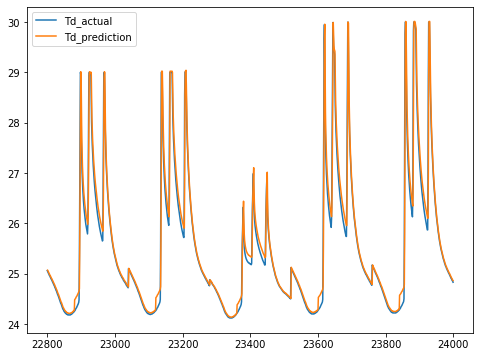

In [10]:
# Plot result
plt.figure(figsize=(8,6))
y_test.Td.plot(label='Td_actual')
Td_pred.plot(label='Td_prediction')
plt.legend()

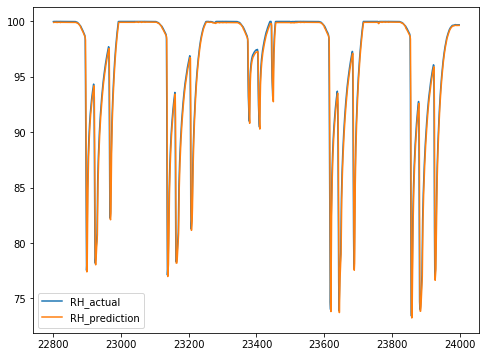

In [11]:
# Plot result
plt.figure(figsize=(8,6))
y_test.RH.plot(label='RH_actual')
RH_pred.plot(label='RH_prediction')
plt.legend()

# NN Controller

In [12]:
yp = y

In [13]:
yr.columns = ['Td','RH']
yr

,Td,RH
0,25,60
1,25,60
2,25,60
3,25,60
4,25,60
...,...,...
23995,25,60
23996,25,60
23997,25,60
23998,25,60


In [28]:
# Memisahkan data tes
yr_temp, yr_test, yp_temp, yp_test = train_test_split(yr, yp, test_size=0.05, shuffle=False, random_state=15)
# Memisahkan data train dan data validation
yr_train, yr_val, yp_train, yp_val = train_test_split(yr_temp, yp_temp, test_size=(15/95), shuffle=False, random_state=2019)

In [29]:
# Membuat model MLP
MLP_AC = MLPRegressor(random_state = 1, hidden_layer_sizes=(91), max_iter = 5000)
MLP_HT = MLPRegressor(random_state = 1, hidden_layer_sizes=(91), max_iter = 5000)

# Membuat model NARX
p_value, q_value, d_value = 1, [1]*2, [0]*2

# # NARX Parallel Architecture
# NARX_Td = NARX(MLP_Td, auto_order=p_value, exog_order=q_value, exog_delay=d_value)
# NARX_RH = NARX(MLP_RH, auto_order=p_value, exog_order=q_value, exog_delay=d_value)

# NARX Series-Parallel Architecture
NARX_AC = DirectAutoRegressor(MLP_AC, auto_order=p_value, exog_order=q_value, exog_delay=d_value, pred_step=1)
NARX_HT = DirectAutoRegressor(MLP_HT, auto_order=p_value, exog_order=q_value, exog_delay=d_value, pred_step=1)

In [16]:
# Training Proses
NARX_AC.fit(yr_train, yp_train.AC)
NARX_HT.fit(yr_train, yp_train.HT)

## Val Prediction

In [17]:
# AC Prediction
AC_pred = NARX_AC.predict(yr_val, X_val.AC)            # NARX Series-Parallel Architecture
AC_pred = pd.Series(AC_pred, index=X_val.index)

# HT Prediction
HT_pred = NARX_HT.predict(yr_val, X_val.HT)            # NARX Series-Parallel Architecture
HT_pred = pd.Series(HT_pred, index=X_val.index)

In [18]:
Xc_val = pd.concat([AC_pred, HT_pred], axis=1)
Xc_val.columns = ['AC','HT']

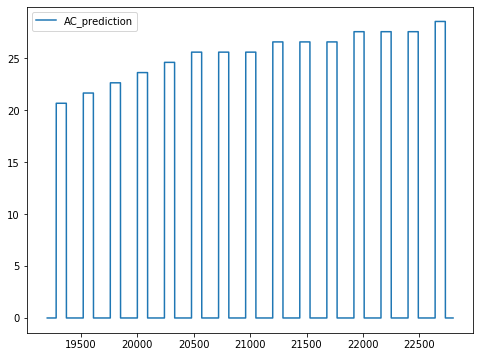

In [19]:
# Plot result
plt.figure(figsize=(8,6))
Xc_val.AC.plot(label='AC_prediction')
plt.legend()

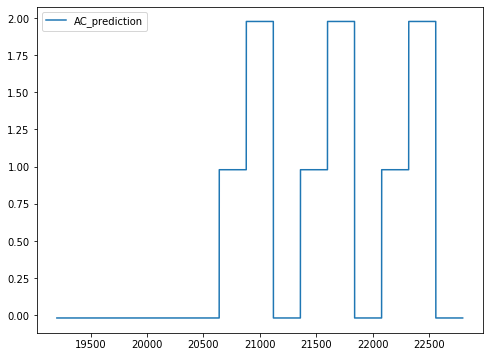

In [20]:
# Plot result
plt.figure(figsize=(8,6))
Xc_val.HT.plot(label='AC_prediction')
plt.legend()

In [21]:
# Td Prediction
Td_pred = NARX_Td.predict(Xc_val, y_val.Td)             # NARX Series-Parallel Architecture
Td_pred = pd.Series(Td_pred, index=y_val.index)

# RH Prediction
RH_pred = NARX_RH.predict(Xc_val, y_val.RH)            # NARX Series-Parallel Architecture
RH_pred = pd.Series(RH_pred, index=y_val.index)

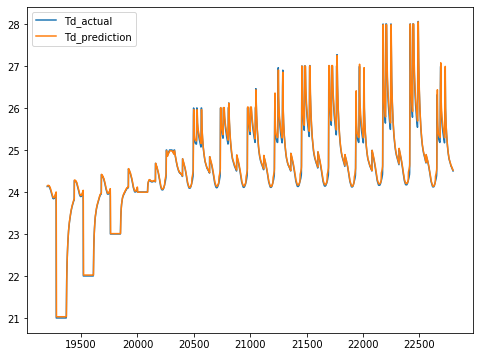

In [22]:
# Plot result
plt.figure(figsize=(8,6))
y_val.Td.plot(label='Td_actual')
Td_pred.plot(label='Td_prediction')
plt.legend()

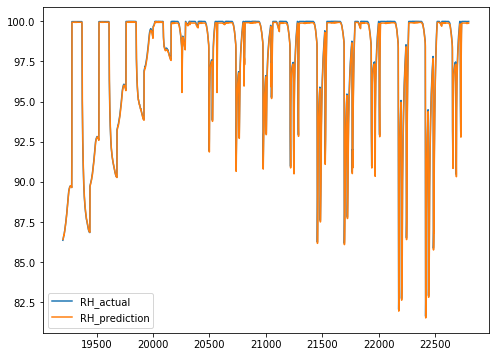

In [23]:
# Plot result
plt.figure(figsize=(8,6))
y_val.RH.plot(label='RH_actual')
RH_pred.plot(label='RH_prediction')
plt.legend()

## Test Prediction

In [24]:
# AC Prediction
AC_pred = NARX_AC.predict(yr_test, X_test.AC)            # NARX Series-Parallel Architecture
AC_pred = pd.Series(AC_pred, index=X_test.index)

# HT Prediction
HT_pred = NARX_HT.predict(yr_test, X_test.HT)            # NARX Series-Parallel Architecture
HT_pred = pd.Series(HT_pred, index=X_test.index)

In [25]:
Xc_test = pd.concat([AC_pred, HT_pred], axis=1)
Xc_test.columns = ['AC','HT']

In [27]:
# Td Performance Evaluation
Td_pred = NARX_Td.predict(Xc_test, y_test.Td)           # NARX Series-Parallel Architecture
Td_pred = pd.Series(Td_pred, index=y_test.index)

EVar = round(kinerja(yr_test.Td, Td_pred, method='evar')*100, 2)
R2   = round(kinerja(yr_test.Td, Td_pred, method='r2')*100, 2)
RMSE = round(kinerja(yr_test.Td, Td_pred, method='mse')**0.5, 2)
MAE  = round(kinerja(yr_test.Td, Td_pred, method='mae'), 2)
print("Td Performance evaluation based on Test Data")
print("EVar = {}% | R2 = {}% | RMSE = {} | MAE = {}".format(EVar, R2, RMSE, MAE))
print()

# RH Performance Evaluation
RH_pred = NARX_RH.predict(Xc_test, y_test.RH)           # NARX Series-Parallel Architecture
RH_pred = pd.Series(RH_pred, index=y_test.index)

EVar = round(kinerja(yr_test.RH, RH_pred, method='evar')*100, 2)
R2   = round(kinerja(yr_test.RH, RH_pred, method='r2')*100, 2)
RMSE = round(kinerja(yr_test.RH, RH_pred, method='mse')**0.5, 2)
MAE  = round(kinerja(yr_test.RH, RH_pred, method='mae'), 2)
print("RH Performance evaluation based on Test Data")
print("EVar = {}% | R2 = {}% | RMSE = {} | MAE = {}".format(EVar, R2, RMSE, MAE))
print()

Td Performance evaluation based on Test Data
EVar = 0.0% | R2 = 0.0% | RMSE = 1.48 | MAE = 1.01

RH Performance evaluation based on Test Data
EVar = 0.0% | R2 = 0.0% | RMSE = 36.71 | MAE = 36.23

